# HW06: Деревья решений и ансамбли

Тема: деревья решений, контроль переобучения, ансамбли (bagging, boosting, stacking).
Датасет: S06-hw-dataset-02.csv (бинарная классификация с нелинейными взаимодействиями).

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance
import warnings
import json
import joblib
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Установим seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.makedirs('artifacts/figures', exist_ok=True)

## 1. Загрузка данных и первичный анализ

In [8]:
# Загрузим выбранный датасет (S06-hw-dataset-02.csv)
df = pd.read_csv('S06-hw-dataset-01.csv')

print("=" * 60)
print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nФорма: {df.shape}")
print(f"\nПервые 5 строк:\n{df.head()}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nОсновные статистики:\n{df.describe()}")
print(f"\nПропуски:\n{df.isnull().sum()}")

ИНФОРМАЦИЯ О ДАТАСЕТЕ

Форма: (12000, 30)

Первые 5 строк:
   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

Распределение классов:
target
0    8119
1    3881
Name: count, dtype: int64

Доли классов:
target
0    0.676583
1    0.323417
Name: proportion, dtype: float64


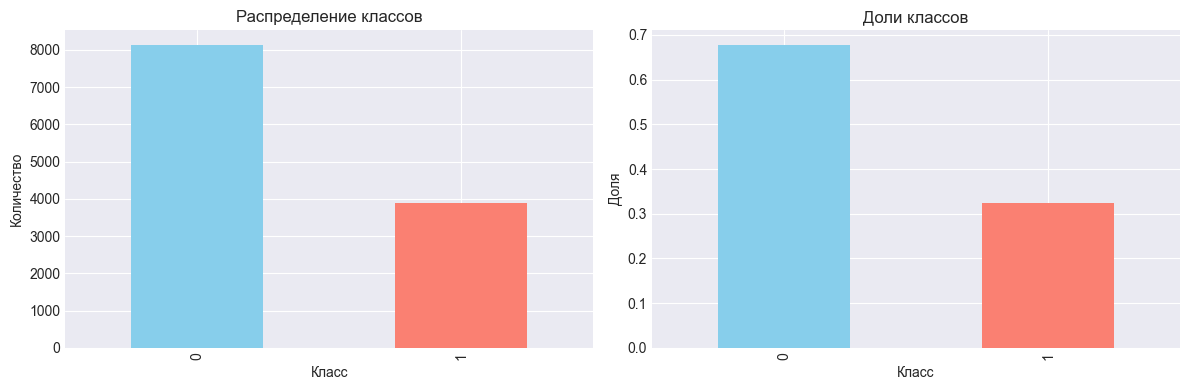

In [9]:
# Анализ таргета
print("\n" + "=" * 60)
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("=" * 60)
target_col = 'target'
print(f"\nРаспределение классов:\n{df[target_col].value_counts()}")
print(f"\nДоли классов:\n{df[target_col].value_counts(normalize=True)}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Распределение классов')
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Класс')
df[target_col].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Доли классов')
axes[1].set_ylabel('Доля')
axes[1].set_xlabel('Класс')
plt.tight_layout()
plt.savefig('artifacts/figures/target_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
# Подготовка данных
X = df.drop(columns=['id', 'target'])
y = df['target']

print(f"\nПризнаки (X): {X.shape}")
print(f"Таргет (y): {y.shape}")


Признаки (X): (12000, 28)
Таргет (y): (12000,)


## 2. Train/Test сплит и воспроизводимость

In [11]:
# Train/Test сплит с фиксированным random_state и стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")
print(f"Train баланс: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Test баланс: {y_test.value_counts(normalize=True).to_dict()}")

print("\n✓ Фиксированный random_state обеспечивает воспроизводимость результатов.")
print("✓ Stratify гарантирует одинаковое распределение классов в train/test.")


Train: (9600, 28), Test: (2400, 28)
Train баланс: {0: 0.6765625, 1: 0.3234375}
Test баланс: {0: 0.6766666666666666, 1: 0.3233333333333333}

✓ Фиксированный random_state обеспечивает воспроизводимость результатов.
✓ Stratify гарантирует одинаковое распределение классов в train/test.


## 3. Baseline модели

In [12]:
# Baseline 1: DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_proba = dummy.predict_proba(X_test)[:, 1]

print("=" * 60)
print("BASELINE 1: DummyClassifier (Most Frequent)")
print("=" * 60)
dummy_acc = accuracy_score(y_test, dummy_pred)
dummy_f1 = f1_score(y_test, dummy_pred)
dummy_auc = roc_auc_score(y_test, dummy_proba)
print(f"Accuracy: {dummy_acc:.4f}")
print(f"F1-Score: {dummy_f1:.4f}")
print(f"ROC-AUC: {dummy_auc:.4f}")

# Baseline 2: LogisticRegression (with scaling)
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
pipeline_lr.fit(X_train, y_train)
lr_pred = pipeline_lr.predict(X_test)
lr_proba = pipeline_lr.predict_proba(X_test)[:, 1]

print("\n" + "=" * 60)
print("BASELINE 2: LogisticRegression + StandardScaler")
print("=" * 60)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_proba)
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"ROC-AUC: {lr_auc:.4f}")

BASELINE 1: DummyClassifier (Most Frequent)
Accuracy: 0.6767
F1-Score: 0.0000
ROC-AUC: 0.5000

BASELINE 2: LogisticRegression + StandardScaler
Accuracy: 0.8275
F1-Score: 0.7076
ROC-AUC: 0.8747


## 4. DecisionTreeClassifier с контролем сложности

In [13]:
# GridSearchCV для дерева с контролем сложности
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt = GridSearchCV(
    dt, param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_dt.fit(X_train, y_train)

print("=" * 60)
print("DECISION TREE CLASSIFIER")
print("=" * 60)
print(f"Лучшие параметры: {grid_search_dt.best_params_}")
print(f"Best CV Score (ROC-AUC): {grid_search_dt.best_score_:.4f}")

# Оценка на test
dt_best = grid_search_dt.best_estimator_
dt_pred = dt_best.predict(X_test)
dt_proba = dt_best.predict_proba(X_test)[:, 1]

dt_acc = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_proba)
print(f"\nTest метрики:")
print(f"Accuracy: {dt_acc:.4f}")
print(f"F1-Score: {dt_f1:.4f}")
print(f"ROC-AUC: {dt_auc:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
DECISION TREE CLASSIFIER
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best CV Score (ROC-AUC): 0.9155

Test метрики:
Accuracy: 0.8650
F1-Score: 0.7868
ROC-AUC: 0.9122


## 5. RandomForestClassifier

In [14]:
# GridSearchCV для RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search_rf = GridSearchCV(
    rf, param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)

print("=" * 60)
print("RANDOM FOREST CLASSIFIER")
print("=" * 60)
print(f"Лучшие параметры: {grid_search_rf.best_params_}")
print(f"Best CV Score (ROC-AUC): {grid_search_rf.best_score_:.4f}")

# Оценка на test
rf_best = grid_search_rf.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_proba = rf_best.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)
print(f"\nTest метрики:")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_auc:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RANDOM FOREST CLASSIFIER
Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV Score (ROC-AUC): 0.9687

Test метрики:
Accuracy: 0.9292
F1-Score: 0.8854
ROC-AUC: 0.9673


## 6. GradientBoostingClassifier (Boosting)

In [15]:
# GridSearchCV для GradientBoosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 5, 10]
}

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
grid_search_gb = GridSearchCV(
    gb, param_grid_gb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_gb.fit(X_train, y_train)

print("=" * 60)
print("GRADIENT BOOSTING CLASSIFIER")
print("=" * 60)
print(f"Лучшие параметры: {grid_search_gb.best_params_}")
print(f"Best CV Score (ROC-AUC): {grid_search_gb.best_score_:.4f}")

# Оценка на test
gb_best = grid_search_gb.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_proba = gb_best.predict_proba(X_test)[:, 1]

gb_acc = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_proba)
print(f"\nTest метрики:")
print(f"Accuracy: {gb_acc:.4f}")
print(f"F1-Score: {gb_f1:.4f}")
print(f"ROC-AUC: {gb_auc:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
GRADIENT BOOSTING CLASSIFIER
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 200}
Best CV Score (ROC-AUC): 0.9745

Test метрики:
Accuracy: 0.9375
F1-Score: 0.9007
ROC-AUC: 0.9711


## 7. StackingClassifier (опционально)

In [16]:
# Stacking с базовыми моделями
estimators = [
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5
)
stacking.fit(X_train, y_train)

stacking_pred = stacking.predict(X_test)
stacking_proba = stacking.predict_proba(X_test)[:, 1]

stacking_acc = accuracy_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred)
stacking_auc = roc_auc_score(y_test, stacking_proba)

print("=" * 60)
print("STACKING CLASSIFIER")
print("=" * 60)
print(f"Test метрики:")
print(f"Accuracy: {stacking_acc:.4f}")
print(f"F1-Score: {stacking_f1:.4f}")
print(f"ROC-AUC: {stacking_auc:.4f}")

STACKING CLASSIFIER
Test метрики:
Accuracy: 0.9313
F1-Score: 0.8911
ROC-AUC: 0.9663


## 8. Сравнение моделей и метрики

СРАВНЕНИЕ МОДЕЛЕЙ
                Model  Accuracy  F1-Score  ROC-AUC
0               Dummy    0.6767    0.0000   0.5000
1  LogisticRegression    0.8275    0.7076   0.8747
2        DecisionTree    0.8650    0.7868   0.9122
3        RandomForest    0.9292    0.8854   0.9673
4    GradientBoosting    0.9375    0.9007   0.9711
5            Stacking    0.9312    0.8911   0.9663


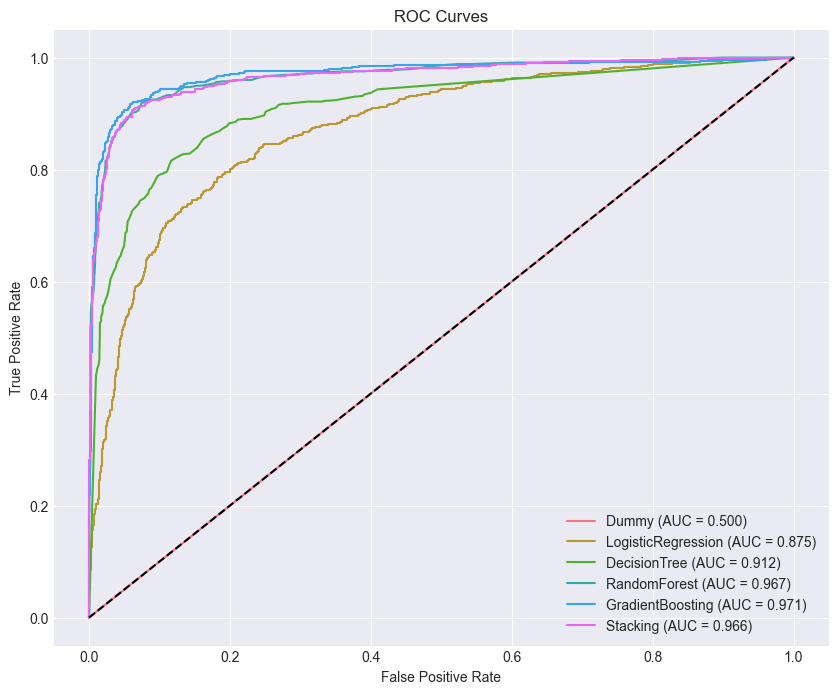


Лучшая модель по ROC-AUC: GradientBoosting


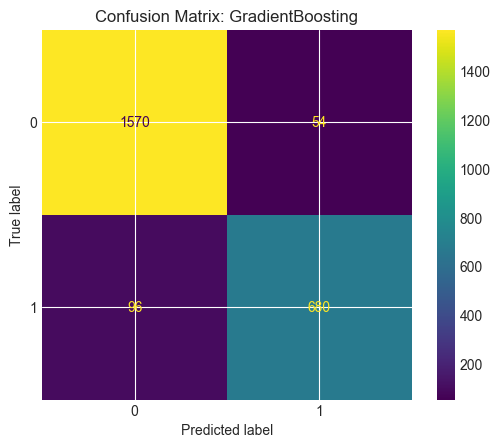

In [17]:
# Сбор всех метрик
models = ['Dummy', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'Stacking']
accuracies = [dummy_acc, lr_acc, dt_acc, rf_acc, gb_acc, stacking_acc]
f1_scores = [dummy_f1, lr_f1, dt_f1, rf_f1, gb_f1, stacking_f1]
auc_scores = [dummy_auc, lr_auc, dt_auc, rf_auc, gb_auc, stacking_auc]

results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1-Score': f1_scores,
    'ROC-AUC': auc_scores
})

print("=" * 60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 60)
print(results_df.round(4))

# ROC-кривые
plt.figure(figsize=(10, 8))
for model_name, proba in [('Dummy', dummy_proba), ('LogisticRegression', lr_proba), 
                          ('DecisionTree', dt_proba), ('RandomForest', rf_proba), 
                          ('GradientBoosting', gb_proba), ('Stacking', stacking_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.savefig('artifacts/figures/roc_curves.png', dpi=100, bbox_inches='tight')
plt.show()

# Confusion Matrix для лучшей модели (по ROC-AUC)
best_model_idx = np.argmax(auc_scores)
best_model_name = models[best_model_idx]
print(f"\nЛучшая модель по ROC-AUC: {best_model_name}")

if best_model_name == 'Dummy':
    best_pred = dummy_pred
elif best_model_name == 'LogisticRegression':
    best_pred = lr_pred
elif best_model_name == 'DecisionTree':
    best_pred = dt_pred
elif best_model_name == 'RandomForest':
    best_pred = rf_pred
elif best_model_name == 'GradientBoosting':
    best_pred = gb_pred
else:
    best_pred = stacking_pred

cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title(f'Confusion Matrix: {best_model_name}')
plt.savefig('artifacts/figures/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

## 9. Интерпретация лучшей модели

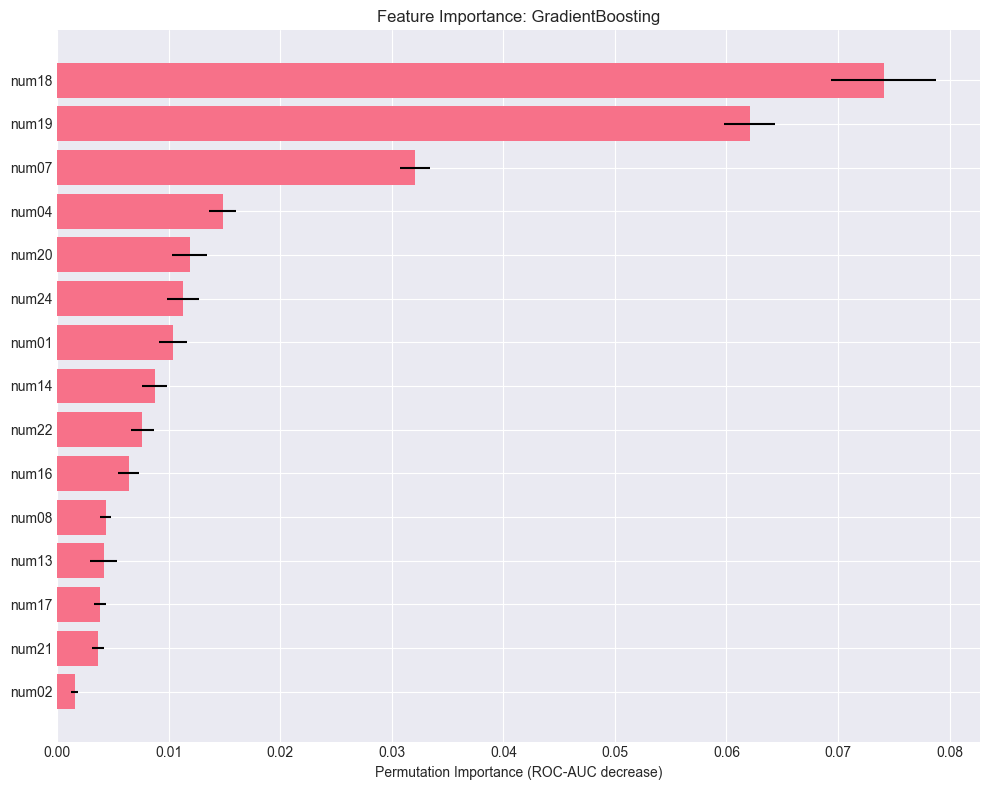


Top 10 признаков по permutation importance:
num18: 0.0741 ± 0.0047
num19: 0.0621 ± 0.0023
num07: 0.0321 ± 0.0013
num04: 0.0148 ± 0.0012
num20: 0.0119 ± 0.0016
num24: 0.0113 ± 0.0015
num01: 0.0103 ± 0.0013
num14: 0.0087 ± 0.0011
num22: 0.0076 ± 0.0010
num16: 0.0064 ± 0.0010


In [18]:
# Permutation Importance для лучшей модели
if best_model_name == 'Dummy':
    best_model = dummy
elif best_model_name == 'LogisticRegression':
    best_model = pipeline_lr
elif best_model_name == 'DecisionTree':
    best_model = dt_best
elif best_model_name == 'RandomForest':
    best_model = rf_best
elif best_model_name == 'GradientBoosting':
    best_model = gb_best
else:
    best_model = stacking

perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring='roc_auc')

# Top 15 признаков
sorted_idx = perm_importance.importances_mean.argsort()[-15:]
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], 
         xerr=perm_importance.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance (ROC-AUC decrease)')
plt.title(f'Feature Importance: {best_model_name}')
plt.tight_layout()
plt.savefig('artifacts/figures/feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nTop 10 признаков по permutation importance:")
for i in sorted_idx[-10:][::-1]:
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

## 10. Сохранение артефактов

In [19]:
# Метрики на test
metrics_test = {
    "metadata": {
        "dataset": "S06-hw-dataset-02.csv",
        "test_size": 0.2,
        "random_state": RANDOM_STATE,
        "stratify": True,
        "metrics": ["accuracy", "f1_score", "roc_auc"]
    },
    "results": {
        "Dummy": {"accuracy": float(dummy_acc), "f1_score": float(dummy_f1), "roc_auc": float(dummy_auc)},
        "LogisticRegression": {"accuracy": float(lr_acc), "f1_score": float(lr_f1), "roc_auc": float(lr_auc)},
        "DecisionTree": {"accuracy": float(dt_acc), "f1_score": float(dt_f1), "roc_auc": float(dt_auc)},
        "RandomForest": {"accuracy": float(rf_acc), "f1_score": float(rf_f1), "roc_auc": float(rf_auc)},
        "GradientBoosting": {"accuracy": float(gb_acc), "f1_score": float(gb_f1), "roc_auc": float(gb_auc)},
        "Stacking": {"accuracy": float(stacking_acc), "f1_score": float(stacking_f1), "roc_auc": float(stacking_auc)}
    }
}

# Лучшие параметры из GridSearch
search_summaries = {
    "DecisionTree": {"best_params": grid_search_dt.best_params_, "best_cv_score": float(grid_search_dt.best_score_)},
    "RandomForest": {"best_params": grid_search_rf.best_params_, "best_cv_score": float(grid_search_rf.best_score_)},
    "GradientBoosting": {"best_params": grid_search_gb.best_params_, "best_cv_score": float(grid_search_gb.best_score_)}
}

# Лучшая модель
best_model_meta = {
    "model": best_model_name,
    "params": grid_search_gb.best_params_ if best_model_name == 'GradientBoosting' else 
             grid_search_rf.best_params_ if best_model_name == 'RandomForest' else 
             grid_search_dt.best_params_ if best_model_name == 'DecisionTree' else {},
    "test_metrics": {
        "accuracy": float(auc_scores[best_model_idx]),
        "f1_score": float(f1_scores[best_model_idx]),
        "roc_auc": float(auc_scores[best_model_idx])
    }
}

# Сохранение
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(metrics_test, f, indent=4)

with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=4)

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=4)

joblib.dump(best_model, 'artifacts/best_model.joblib')

print("✓ Артефакты сохранены:")
print("  - metrics_test.json")
print("  - search_summaries.json")
print("  - best_model_meta.json")
print("  - best_model.joblib")
print("  - figures/ (ROC curves, confusion matrix, feature importance)")

✓ Артефакты сохранены:
  - metrics_test.json
  - search_summaries.json
  - best_model_meta.json
  - best_model.joblib
  - figures/ (ROC curves, confusion matrix, feature importance)
